# Demonstration of Neural Style Transfer
## by Dattaraj Rao (dattarajrao@yahoo.com)

###This code is highly inspired by the following Medium post by Google's Tensorflow team.
https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398

In [0]:
# Check if GPU device is available
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# First we will load the VGG19 model and study it.
## We will create a new Model that extracts the convolutional layers from it.

In [0]:
# import tensorflow libraries
import tensorflow as tf
# load the easy execution library
import tensorflow.contrib.eager as tfe
import time

# enable easger execution - this should be done at start of program
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

# load the model from keras with imagenet weights
vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg19.trainable = False
vgg19.summary()

Eager execution: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',\
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

# get counters for style and content layers
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Get output layers corresponding to style and content layers 
style_outputs = [vgg19.get_layer(name).output for name in style_layers]
content_outputs = [vgg19.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

# Build model 
style_model = tf.keras.models.Model(vgg19.input, model_outputs)

# Load the style and content images


In [0]:
# lets download style and content image files
!wget -O mycontent.jpg https://pbs.twimg.com/profile_images/872804244910358528/w5H_uzUD_400x400.jpg
!wget -O mystyle.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

--2018-12-21 10:39:20--  https://pbs.twimg.com/profile_images/872804244910358528/w5H_uzUD_400x400.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 72.21.91.70, 2606:2800:220:1410:489:141e:20bb:12f6
Connecting to pbs.twimg.com (pbs.twimg.com)|72.21.91.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18685 (18K) [image/jpeg]
Saving to: ‘mycontent.jpg’

mycontent.jpg       100%[===================>]  18.25K  --.-KB/s    in 0s      

2018-12-21 10:39:20 (172 MB/s) - ‘mycontent.jpg’ saved [18685/18685]

--2018-12-21 10:39:23--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1363698 (1.3M) [image/jpeg]
Saving to: ‘m

Using TensorFlow backend.


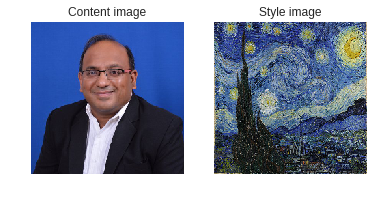

In [0]:
# import the plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

# impot numpy
import numpy as np
# import preprocvessing functions for preparing image
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input

content_path = 'mycontent.jpg'
style_path = 'mystyle.jpg'

# load content and style images in memory
content = image.load_img(content_path, target_size=(224, 224))
style = image.load_img(style_path, target_size=(224, 224))

# convert style and content images as arrays
content_x = image.img_to_array(content)
content_x = np.expand_dims(content_x, axis=0)
content_x = preprocess_input(content_x)

style_x = image.img_to_array(style)
style_x = np.expand_dims(style_x, axis=0)
style_x = preprocess_input(style_x)

# show the images loaded
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Content image')
plt.imshow(content)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Style image')
plt.imshow(style)
plt.show()

In [0]:
# define a few helper functions

# get real pixel values from normalized result generated by model
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)

  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  # remove any values below 0 and above 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

# define the content loss as distance between content and target 
def get_content_loss(base_content, target): 
  return tf.reduce_mean(tf.square(base_content - target))

# to get style loss first we should calculate gram matrix
def gram_matrix(input_tensor):
  # make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  # gram matrix is obtained by multiplying matrxi with transpose
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

# caklculate the style loss
def get_style_loss(base_style, gram_target):
  # we scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

# calculate total loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  # our model is callable just like any other function
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # accumulate style losses from all layers
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

# function to compute gradients
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

# compute our content and style feature representations
def get_feature_representations(model, content_path, style_path):
  # batch compute content and style features
  style_outputs = model(style_x)
  content_outputs = model(content_x)  
  
  # get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

# display image function
def display_result(p_image):
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(p_image)
  plt.show()  

In [0]:
# main function to actually run the style transfer
def run_style_transfer(num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # we will set layers as not trainable since we are not learning
  model = style_model
  for layer in style_model.layers:
    layer.trainable = False
  
  # get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(style_model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # set initial image as our content image
  init_image = content_x.copy()
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # lets build an Adam optimizer
  opt = tf.train.AdamOptimizer(learning_rate=2.0, beta1=0.99, epsilon=1e-1)

  # for displaying intermediate images 
  iter_count = 1
  
  # wtore our best result
  best_loss, best_img = float('inf'), None
  
  # define loss terms and build a config object
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': style_model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # for displaying results
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()

  # means of each channel for nomalization
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  # perform optimization and get the intermediate generated images
  # work with init_image and modify it through optimization
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # update best loss and best image from total loss. 
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # define title for image
      print ('Iteration: {}'.format(i))        

      print ('Total loss: {:.4e}, ' 
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
      
      # use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      display_result(plot_img)

  print('Total time: {:.4f}s'.format(time.time() - global_start))

  return best_img, best_loss 

Iteration: 0
Total loss: 6.4202e+08, style loss: 6.4202e+08, content loss: 0.0000e+00, time: 0.0005s


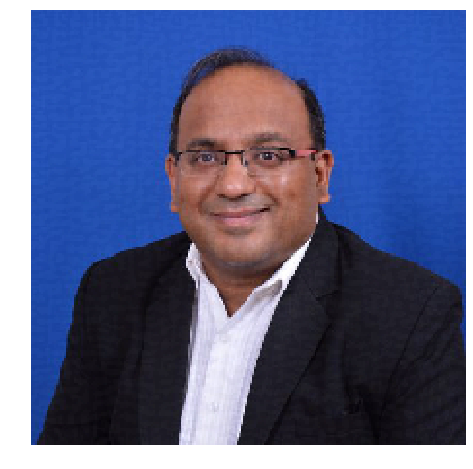

Iteration: 5
Total loss: 1.9936e+08, style loss: 1.9574e+08, content loss: 3.6110e+06, time: 0.0002s


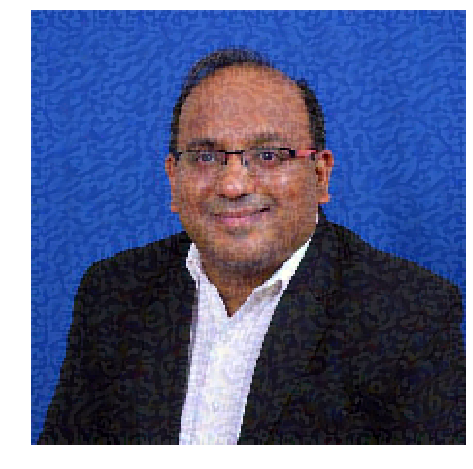

Iteration: 10
Total loss: 7.4516e+07, style loss: 6.9712e+07, content loss: 4.8046e+06, time: 0.0001s


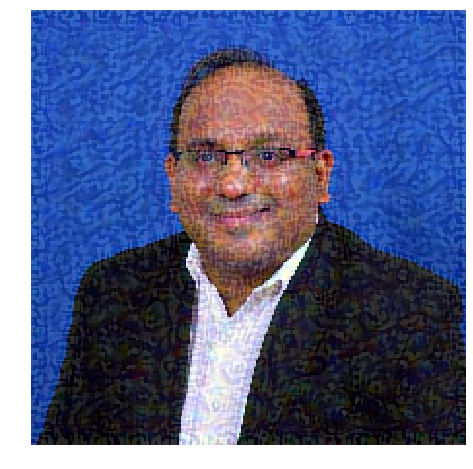

Iteration: 15
Total loss: 6.9907e+07, style loss: 6.4270e+07, content loss: 5.6375e+06, time: 0.0002s


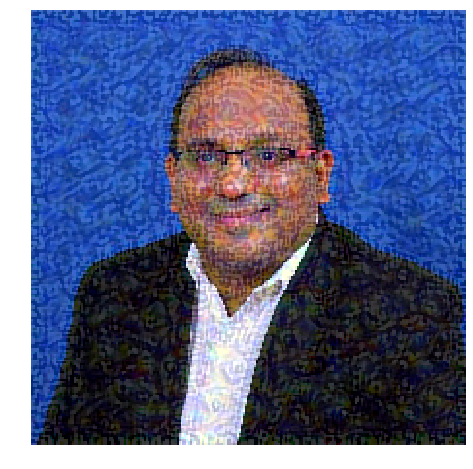

Iteration: 20
Total loss: 5.8455e+07, style loss: 5.2220e+07, content loss: 6.2356e+06, time: 0.0005s


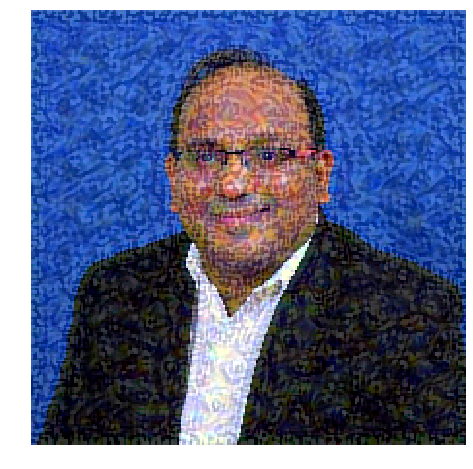

Iteration: 25
Total loss: 4.4365e+07, style loss: 3.7659e+07, content loss: 6.7060e+06, time: 0.0006s


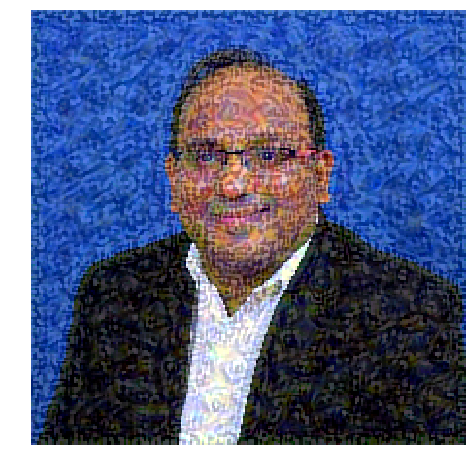

Iteration: 30
Total loss: 3.7570e+07, style loss: 3.0506e+07, content loss: 7.0640e+06, time: 0.0002s


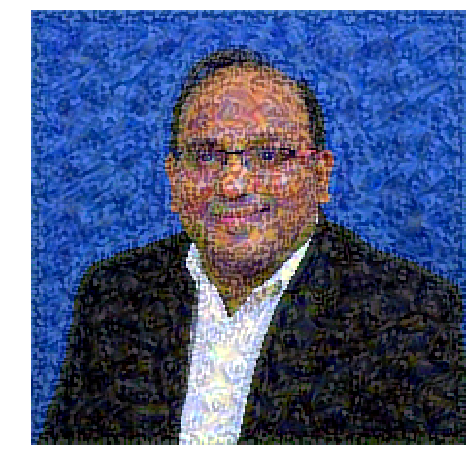

Iteration: 35
Total loss: 3.2643e+07, style loss: 2.5412e+07, content loss: 7.2316e+06, time: 0.0002s


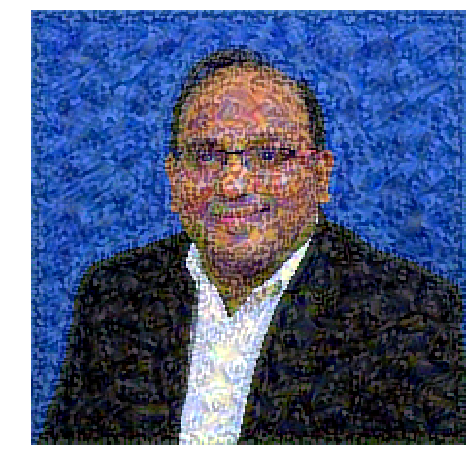

Iteration: 40
Total loss: 2.9691e+07, style loss: 2.2418e+07, content loss: 7.2734e+06, time: 0.0005s


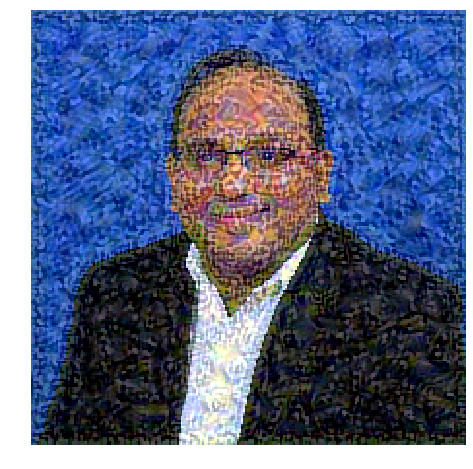

Iteration: 45
Total loss: 2.7569e+07, style loss: 2.0306e+07, content loss: 7.2623e+06, time: 0.0002s


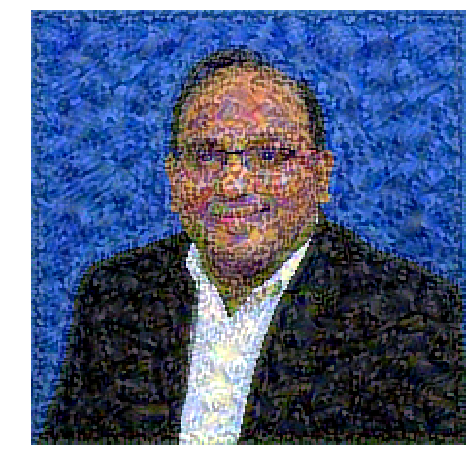

Total time: 7.6633s


In [0]:
best, best_loss = run_style_transfer(num_iterations=50)